In [1]:
from __future__ import print_function
import sys
import os
import numpy as np
import google.protobuf as pb
import IPython.display as display
from os.path import expanduser, join
import matplotlib.pyplot as plt
%matplotlib inline

# plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# caffe paths and import
home_dir = expanduser('~')
caffe_root = os.path.join(home_dir, 'code/caffe')
sys.path.append(join(caffe_root, "python"))
import caffe
import caffe.draw

In [3]:
# plot net
def plot_net(file_path):
    net = caffe.proto.caffe_pb2.NetParameter()
    f = open(file_path)
    pb.text_format.Merge(f.read(), net)
    f.close()
    display.display(display.Image(caffe.draw.get_pydot_graph(net, "TB").create_png()))

# plot_net(join(caffe_root, 'examples/mnist/lenet_train_test.prototxt'))

def vis_square(data, padsize=1, padval=0):
    """
    Visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
    
    Input:
        data: array of shape (n, height, width) or (n, height, width, channels)
    
    Notes:
        required     : (n * h * w * c)
        caffe default: (n * c * h * w)
        do transpose : filter.transpose(0, 2, 3, 1)
    """
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

In [4]:
# init solver
caffe.set_mode_gpu()
caffe.set_device(0)
solver = caffe.SGDSolver(join(caffe_root, 'examples/mnist/lenet_solver.prototxt'))

In [5]:
# feature maps
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('ip1', (64, 500)),
 ('ip2', (64, 10)),
 ('loss', ())]

In [6]:
# parameters
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('ip1', (500, 800)),
 ('ip2', (10, 500))]

In [7]:
# train net
solver.net.forward()
solver.test_nets[0].forward()  # test net (there can be more than one)

{'accuracy': array(0.05999999865889549, dtype=float32),
 'loss': array(2.422696113586426, dtype=float32)}

[ 5.  0.  4.  1.  9.  2.  1.  3.]


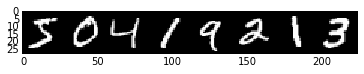

In [8]:
# tile the first eight train images
plt.imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')
print(solver.net.blobs['label'].data[:8])
# plt.imshow(solver.net.blobs['data'].data[:1, 0].reshape(28, 28), cmap='gray')

[ 7.  2.  1.  0.  4.  1.  4.  9.]


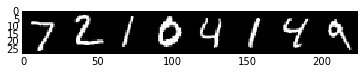

In [9]:
# tile the first eight test images
plt.imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')
print(solver.test_nets[0].blobs['label'].data[:8])

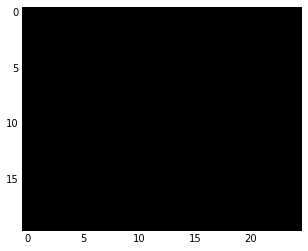

In [10]:
# visulize conv1 grad 
plt.imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
           .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

# other ways to visulize conv1 grad
# vis_square(solver.net.params['conv1'][0].diff[:, 0])
# vis_square(solver.net.params['conv1'][0].diff.reshape(20, 5, 5))

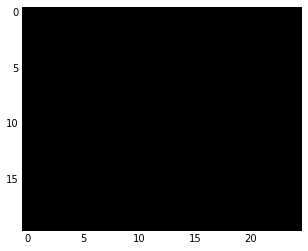

In [11]:
# after forward
solver.net.forward()
plt.imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
           .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

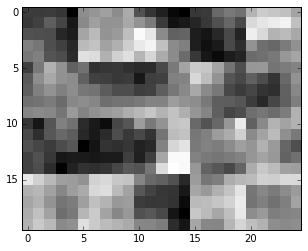

In [12]:
# after step
solver.step(1)
plt.imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
           .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

In [13]:
%%time
niter = 200
test_interval = 25

# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))
output = np.zeros((niter, 5, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:5] # stores the first 5 test results
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print('Iteration', it, 'testing...')
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 1.99 s, sys: 952 ms, total: 2.94 s
Wall time: 1.51 s


In [14]:
solver.test_nets[0].blobs['ip2'].data[:5].shape

(5, 10)

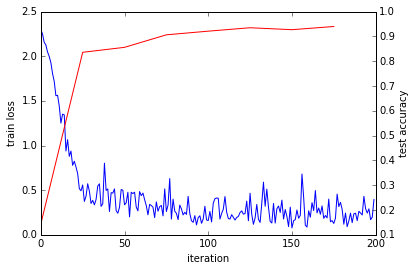

In [15]:
# plot loss
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

IndexError: index 5 is out of bounds for axis 1 with size 5

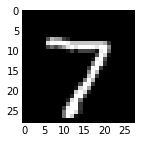

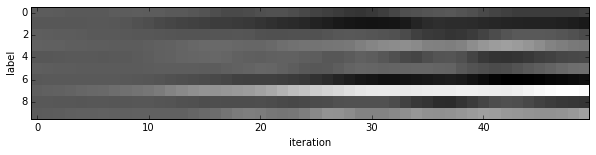

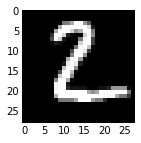

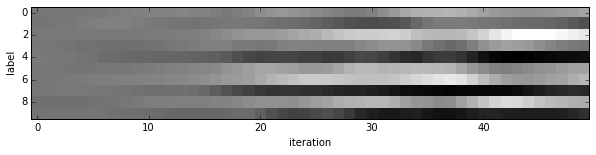

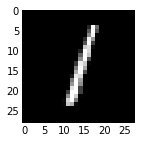

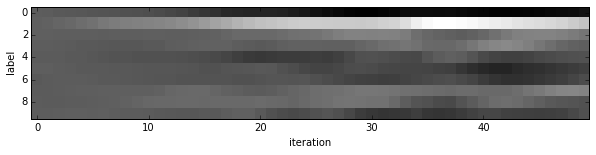

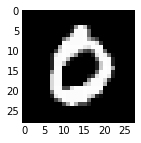

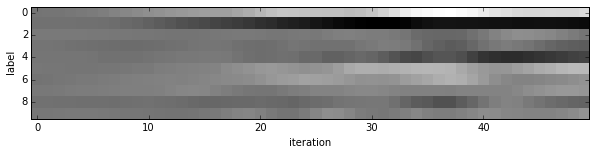

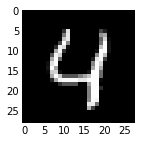

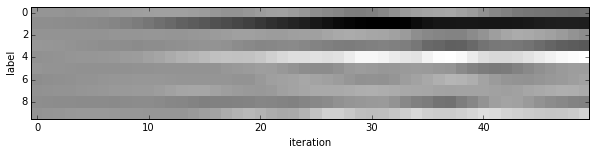

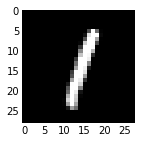

In [16]:
# watch how predictions of the first 5 test samples evolve
for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    plt.figure(figsize=(10, 2))
    plt.imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    plt.xlabel('iteration')
    plt.ylabel('label')